# 03 - Feature Engineering

This notebook creates features for the recommendation models:
- User-item interaction matrix
- Movie features (genres, year, popularity)
- User profiles (preferences, activity)
- Temporal features
- Save processed features for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import pickle

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Paths

In [3]:
# Load project config
project_root = Path.cwd().parent
config_path = project_root / 'config' / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Data paths
processed_dir = project_root / config['data']['processed_dir']
features_dir = project_root / config['data']['features_dir']
features_dir.mkdir(parents=True, exist_ok=True)

print(f"Processed data directory: {processed_dir}")
print(f"Features directory: {features_dir}")

Processed data directory: c:\Users\ololi\StudioProjects\movie-recommender\data\processed
Features directory: c:\Users\ololi\StudioProjects\movie-recommender\data\features


## 2. Load Cleaned Data

In [4]:
print("Loading cleaned data...")

ratings = pd.read_parquet(processed_dir / 'ratings_cleaned.parquet')
movies = pd.read_parquet(processed_dir / 'movies_cleaned.parquet')
links = pd.read_parquet(processed_dir / 'links_cleaned.parquet')
tags = pd.read_parquet(processed_dir / 'tags_cleaned.parquet')

print(f"\nLoaded:")
print(f"  Ratings: {len(ratings):,}")
print(f"  Movies: {len(movies):,}")
print(f"  Links: {len(links):,}")
print(f"  Tags: {len(tags):,}")

# Display sample
print("\nSample ratings:")
ratings.head()

Loading cleaned data...

Loaded:
  Ratings: 24,914,810
  Movies: 32,424
  Links: 32,424
  Tags: 1,034,097

Sample ratings:


,userId,movieId,rating,timestamp,datetime
0,1,296,5.0,1147880044,2006-05-17 15:34:04
1,1,306,3.5,1147868817,2006-05-17 12:26:57
2,1,307,5.0,1147868828,2006-05-17 12:27:08
3,1,665,5.0,1147878820,2006-05-17 15:13:40
4,1,899,3.5,1147868510,2006-05-17 12:21:50


## 3. Create User-Item Interaction Matrix

In [5]:
print("Creating user-item interaction matrix...")

# Create user and movie ID mappings (0-indexed)
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_id_map = {user_id: idx for idx, user_id in enumerate(sorted(user_ids))}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(sorted(movie_ids))}

# Reverse mappings
idx_to_user = {idx: user_id for user_id, idx in user_id_map.items()}
idx_to_movie = {idx: movie_id for movie_id, idx in movie_id_map.items()}

print(f"  Users: {len(user_id_map):,}")
print(f"  Movies: {len(movie_id_map):,}")

# Map ratings to matrix indices
ratings['user_idx'] = ratings['userId'].map(user_id_map)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_map)

# Create sparse matrix
user_item_matrix = csr_matrix(
    (ratings['rating'].values, 
     (ratings['user_idx'].values, ratings['movie_idx'].values)),
    shape=(len(user_id_map), len(movie_id_map))
)

print(f"\nMatrix shape: {user_item_matrix.shape}")
print(f"Matrix density: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.4%}")
print(f"Matrix size in memory: {user_item_matrix.data.nbytes / 1024**2:.1f} MB")

Creating user-item interaction matrix...
  Users: 162,112
  Movies: 32,424

Matrix shape: (162112, 32424)
Matrix density: 0.4740%
Matrix size in memory: 190.1 MB


## 4. Extract Movie Features

### 4.1 Genre Features

In [6]:
print("Extracting genre features...")

# Parse genres (pipe-separated)
movies['genres_list'] = movies['genres'].str.split('|')

# Get unique genres
all_genres = set()
for genres in movies['genres_list']:
    all_genres.update(genres)

all_genres = sorted(all_genres)
print(f"  Unique genres: {len(all_genres)}")
print(f"  Genres: {', '.join(all_genres)}")

# Create multi-hot encoded genre features
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies['genres_list'])
genre_df = pd.DataFrame(
    genre_features, 
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=movies.index
)

print(f"\n  Genre feature matrix shape: {genre_df.shape}")

# Add to movies dataframe
movies = pd.concat([movies, genre_df], axis=1)

# Genre distribution
genre_counts = genre_df.sum().sort_values(ascending=False)
print(f"\n  Top 5 genres:")
for genre, count in genre_counts.head().items():
    print(f"    {genre.replace('genre_', '')}: {int(count):,} movies")

Extracting genre features...
  Unique genres: 20
  Genres: (no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

  Genre feature matrix shape: (32424, 20)

  Top 5 genres:
    Drama: 14,706 movies
    Comedy: 9,916 movies
    Thriller: 5,223 movies
    Romance: 4,483 movies
    Action: 4,262 movies


### 4.2 Year Features

In [8]:
print("Extracting year features...")

# Year statistics
print(f"  Year range: {movies['year'].min():.0f} - {movies['year'].max():.0f}")
print(f"  Movies with year: {movies['year'].notna().sum():,} ({movies['year'].notna().sum()/len(movies)*100:.1f}%)")

# Fill missing years with median
median_year = movies['year'].median()
movies['year_filled'] = movies['year'].fillna(median_year)

# Create decade feature
movies['decade'] = (movies['year_filled'] // 10 * 10).astype(int)

# Create age feature (years since release)
current_year = 2015  # Approximate year of dataset
movies['age'] = current_year - movies['year_filled']

# Create era categories
def categorize_era(year):
    if pd.isna(year):
        return 'Unknown'
    elif year < 1960:
        return 'Classic'
    elif year < 1980:
        return 'Vintage'
    elif year < 2000:
        return 'Modern'
    else:
        return 'Contemporary'

movies['era'] = movies['year'].apply(categorize_era)

print(f"\n  Era distribution:")
print(movies['era'].value_counts().sort_index())

Extracting year features...
  Year range: 1874 - 2019
  Movies with year: 32,336 (99.7%)

  Era distribution:
era
Classic          3413
Contemporary    18222
Modern           7023
Unknown            88
Vintage          3678
Name: count, dtype: int64


### 4.3 Popularity Features

In [9]:
print("Calculating popularity features...")

# Aggregate rating statistics per movie
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std', 'min', 'max']
}).reset_index()

movie_stats.columns = ['movieId', 'num_ratings', 'avg_rating', 'std_rating', 'min_rating', 'max_rating']

# Fill missing std (single rating movies)
movie_stats['std_rating'] = movie_stats['std_rating'].fillna(0)

# Popularity score (log-scaled rating count)
movie_stats['popularity'] = np.log1p(movie_stats['num_ratings'])

# Weighted rating (Bayesian average)
C = movie_stats['avg_rating'].mean()  # Mean rating across all movies
m = movie_stats['num_ratings'].quantile(0.75)  # Minimum ratings threshold

movie_stats['weighted_rating'] = (
    (movie_stats['num_ratings'] * movie_stats['avg_rating'] + m * C) / 
    (movie_stats['num_ratings'] + m)
)

# Merge with movies
movies = movies.merge(movie_stats, on='movieId', how='left')

print(f"  Rating count range: {movie_stats['num_ratings'].min()} - {movie_stats['num_ratings'].max():,}")
print(f"  Average rating range: {movie_stats['avg_rating'].min():.2f} - {movie_stats['avg_rating'].max():.2f}")
print(f"  Popularity range: {movie_stats['popularity'].min():.2f} - {movie_stats['popularity'].max():.2f}")

Calculating popularity features...
  Rating count range: 5 - 81,394
  Average rating range: 0.50 - 4.50
  Popularity range: 1.79 - 11.31


### 4.4 Tag Features

In [10]:
print("Processing tag features...")

# Count tags per movie
tag_counts = tags.groupby('movieId').size().reset_index(name='num_tags')

# Get unique tags per movie
movie_tags = tags.groupby('movieId')['tag'].apply(list).reset_index()
movie_tags['unique_tags'] = movie_tags['tag'].apply(lambda x: len(set(x)))

# Merge with movies
movies = movies.merge(tag_counts, on='movieId', how='left')
movies = movies.merge(movie_tags[['movieId', 'unique_tags']], on='movieId', how='left')

# Fill missing tag counts
movies['num_tags'] = movies['num_tags'].fillna(0).astype(int)
movies['unique_tags'] = movies['unique_tags'].fillna(0).astype(int)

print(f"  Movies with tags: {(movies['num_tags'] > 0).sum():,}")
print(f"  Average tags per movie: {movies['num_tags'].mean():.1f}")
print(f"  Max tags for a movie: {movies['num_tags'].max():,}")

Processing tag features...
  Movies with tags: 28,569
  Average tags per movie: 31.9
  Max tags for a movie: 6,180


## 5. Generate User Features

### 5.1 User Activity Features

In [11]:
print("Generating user activity features...")

# Aggregate user statistics
user_stats = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std', 'min', 'max'],
    'timestamp': ['min', 'max']
}).reset_index()

user_stats.columns = ['userId', 'num_ratings', 'avg_rating', 'std_rating', 
                      'min_rating', 'max_rating', 'first_rating_time', 'last_rating_time']

# Fill missing std
user_stats['std_rating'] = user_stats['std_rating'].fillna(0)

# User activity span (days)
user_stats['activity_span_days'] = (
    (user_stats['last_rating_time'] - user_stats['first_rating_time']) / (24 * 3600)
).astype(int)

# Rating frequency (ratings per day)
user_stats['rating_frequency'] = user_stats['num_ratings'] / (user_stats['activity_span_days'] + 1)

print(f"  User rating count range: {user_stats['num_ratings'].min()} - {user_stats['num_ratings'].max():,}")
print(f"  User avg rating range: {user_stats['avg_rating'].min():.2f} - {user_stats['avg_rating'].max():.2f}")
print(f"  User activity span range: {user_stats['activity_span_days'].min()} - {user_stats['activity_span_days'].max():,} days")

user_stats.head()

Generating user activity features...
  User rating count range: 20 - 22,213
  User avg rating range: 0.53 - 4.97
  User activity span range: 0 - 8,101 days


,userId,num_ratings,avg_rating,std_rating,min_rating,max_rating,first_rating_time,last_rating_time,activity_span_days,rating_frequency
0,1,70,3.814286,1.004235,0.5,5.0,1147868053,1147880055,0,70.000000
1,2,184,3.630435,1.457728,0.5,5.0,1141415509,1141418008,0,184.000000
2,3,656,3.697409,0.599854,2.0,5.0,1439472199,1566091883,1465,0.447476
3,4,241,3.379668,1.118985,0.5,5.0,1573937091,1574195101,2,80.333333
4,5,101,3.752475,0.931729,2.0,5.0,830786155,858628421,322,0.312693


### 5.2 User Genre Preferences

In [12]:
print("Calculating user genre preferences...")

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(
    movies[['movieId', 'genres_list']], 
    on='movieId'
)

# Explode genres (one row per genre per rating)
ratings_exploded = ratings_with_genres.explode('genres_list')

# Calculate average rating per user per genre
user_genre_prefs = ratings_exploded.groupby(['userId', 'genres_list']).agg({
    'rating': ['mean', 'count']
}).reset_index()

user_genre_prefs.columns = ['userId', 'genre', 'avg_rating', 'count']

# Pivot to wide format (users x genres)
user_genre_matrix = user_genre_prefs.pivot_table(
    index='userId',
    columns='genre',
    values='avg_rating',
    fill_value=0
)

# Rename columns
user_genre_matrix.columns = [f'pref_{col}' for col in user_genre_matrix.columns]
user_genre_matrix = user_genre_matrix.reset_index()

print(f"  User genre preference matrix shape: {user_genre_matrix.shape}")
print(f"  Sample user genre preferences:")
user_genre_matrix.head()

Calculating user genre preferences...
  User genre preference matrix shape: (162112, 21)
  Sample user genre preferences:


,userId,pref_(no genres listed),pref_Action,pref_Adventure,pref_Animation,pref_Children,pref_Comedy,pref_Crime,pref_Documentary,pref_Drama,...,pref_Film-Noir,pref_Horror,pref_IMAX,pref_Musical,pref_Mystery,pref_Romance,pref_Sci-Fi,pref_Thriller,pref_War,pref_Western
0,1,0.0,4.125000,3.727273,4.000000,3.833333,3.869565,4.062500,2.000000,3.867925,...,3.5,3.500000,0.000000,3.700000,3.500000,4.166667,3.700000,4.300000,3.900000,2.500000
1,2,0.0,3.696970,3.906667,3.617647,3.660000,3.317460,3.138889,0.000000,3.571429,...,0.0,4.000000,4.750000,3.272727,3.687500,3.161765,4.017857,3.833333,3.433333,2.500000
2,3,3.5,3.640719,3.689394,3.980000,3.708333,3.454545,3.886364,3.166667,3.890086,...,4.3,3.544444,3.734568,3.583333,3.891667,3.533333,3.696429,3.692469,3.692308,3.750000
3,4,0.0,3.186207,3.074561,3.483333,3.214286,3.611111,3.972973,4.375000,3.744898,...,0.0,3.150000,2.426829,3.642857,3.805556,3.450000,3.166667,3.544643,3.333333,2.833333
4,5,0.0,3.722222,3.857143,3.750000,3.333333,3.571429,4.142857,0.000000,3.822222,...,0.0,4.666667,4.000000,3.714286,4.714286,3.550000,4.090909,4.000000,4.500000,3.000000


### 5.3 User Temporal Features

In [13]:
print("Extracting user temporal features...")

# Convert timestamp to datetime
ratings['hour'] = pd.to_datetime(ratings['datetime']).dt.hour
ratings['day_of_week'] = pd.to_datetime(ratings['datetime']).dt.dayofweek
ratings['month'] = pd.to_datetime(ratings['datetime']).dt.month
ratings['year'] = pd.to_datetime(ratings['datetime']).dt.year

# User's preferred rating time (hour of day)
user_temporal = ratings.groupby('userId').agg({
    'hour': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
    'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
    'month': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean()
}).reset_index()

user_temporal.columns = ['userId', 'preferred_hour', 'preferred_day', 'preferred_month']

print(f"  User temporal features shape: {user_temporal.shape}")
user_temporal.head()

Extracting user temporal features...
  User temporal features shape: (162112, 4)


,userId,preferred_hour,preferred_day,preferred_month
0,1,12,2,5
1,2,20,4,3
2,3,13,3,8
3,4,21,5,11
4,5,19,0,3


### 5.4 Combine User Features

In [14]:
print("Combining user features...")

# Merge all user features
user_features = user_stats.copy()
user_features = user_features.merge(user_genre_matrix, on='userId', how='left')
user_features = user_features.merge(user_temporal, on='userId', how='left')

# Fill missing values
user_features = user_features.fillna(0)

print(f"\n  Combined user features shape: {user_features.shape}")
print(f"  Features per user: {user_features.shape[1] - 1}")
print(f"\n  Sample user features:")
user_features.head()

Combining user features...

  Combined user features shape: (162112, 33)
  Features per user: 32

  Sample user features:


,userId,num_ratings,avg_rating,std_rating,min_rating,max_rating,first_rating_time,last_rating_time,activity_span_days,rating_frequency,...,pref_Musical,pref_Mystery,pref_Romance,pref_Sci-Fi,pref_Thriller,pref_War,pref_Western,preferred_hour,preferred_day,preferred_month
0,1,70,3.814286,1.004235,0.5,5.0,1147868053,1147880055,0,70.000000,...,3.700000,3.500000,4.166667,3.700000,4.300000,3.900000,2.500000,12,2,5
1,2,184,3.630435,1.457728,0.5,5.0,1141415509,1141418008,0,184.000000,...,3.272727,3.687500,3.161765,4.017857,3.833333,3.433333,2.500000,20,4,3
2,3,656,3.697409,0.599854,2.0,5.0,1439472199,1566091883,1465,0.447476,...,3.583333,3.891667,3.533333,3.696429,3.692469,3.692308,3.750000,13,3,8
3,4,241,3.379668,1.118985,0.5,5.0,1573937091,1574195101,2,80.333333,...,3.642857,3.805556,3.450000,3.166667,3.544643,3.333333,2.833333,21,5,11
4,5,101,3.752475,0.931729,2.0,5.0,830786155,858628421,322,0.312693,...,3.714286,4.714286,3.550000,4.090909,4.000000,4.500000,3.000000,19,0,3


## 6. Visualize Features

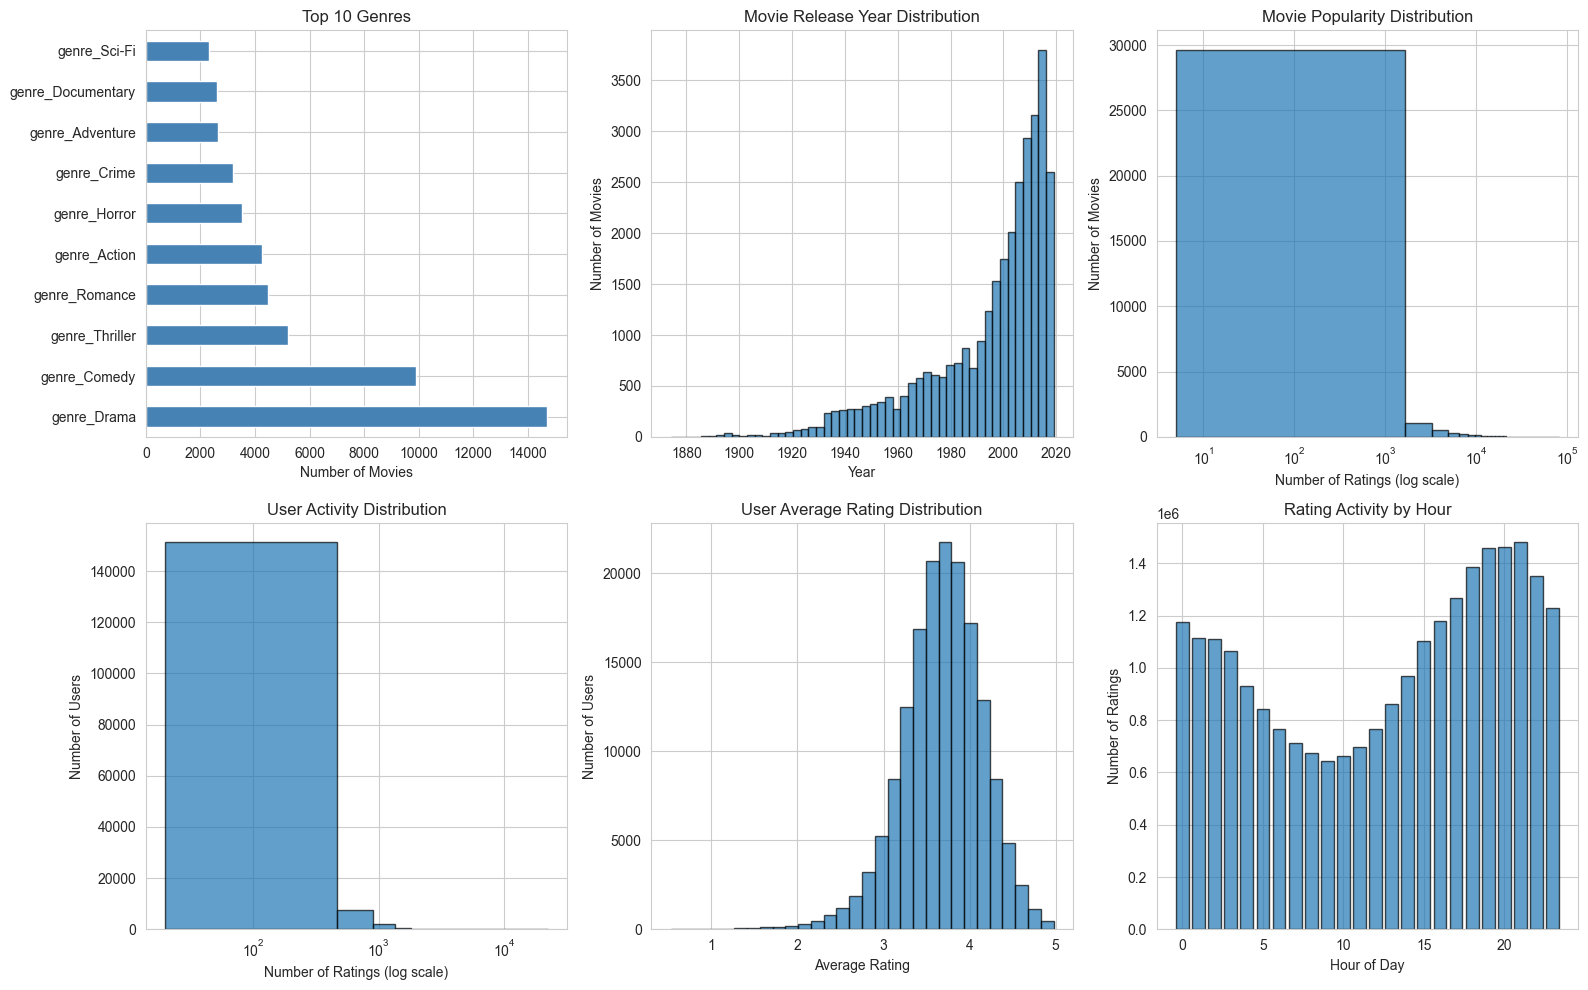

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Genre distribution
genre_counts = movies[[col for col in movies.columns if col.startswith('genre_')]].sum().sort_values(ascending=False).head(10)
genre_counts.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Top 10 Genres')
axes[0, 0].set_xlabel('Number of Movies')

# Movie year distribution
axes[0, 1].hist(movies['year'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Movie Release Year Distribution')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Movies')

# Movie popularity distribution
axes[0, 2].hist(movies['num_ratings'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Movie Popularity Distribution')
axes[0, 2].set_xlabel('Number of Ratings (log scale)')
axes[0, 2].set_ylabel('Number of Movies')
axes[0, 2].set_xscale('log')

# User activity distribution
axes[1, 0].hist(user_features['num_ratings'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('User Activity Distribution')
axes[1, 0].set_xlabel('Number of Ratings (log scale)')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_xscale('log')

# User rating distribution
axes[1, 1].hist(user_features['avg_rating'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('User Average Rating Distribution')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Number of Users')

# Rating timestamp distribution (hour of day)
hour_dist = ratings['hour'].value_counts().sort_index()
axes[1, 2].bar(hour_dist.index, hour_dist.values, alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Rating Activity by Hour')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Number of Ratings')

plt.tight_layout()
plt.show()

## 7. Save Processed Features

In [16]:
print("Saving processed features...\n")

# Save user-item matrix (sparse)
matrix_path = features_dir / 'user_item_matrix.npz'
from scipy.sparse import save_npz
save_npz(matrix_path, user_item_matrix)
print(f"✓ Saved user-item matrix to: {matrix_path}")
print(f"  Size: {matrix_path.stat().st_size / 1024**2:.1f} MB")

# Save ID mappings
mappings = {
    'user_id_map': user_id_map,
    'movie_id_map': movie_id_map,
    'idx_to_user': idx_to_user,
    'idx_to_movie': idx_to_movie
}
mappings_path = features_dir / 'id_mappings.pkl'
with open(mappings_path, 'wb') as f:
    pickle.dump(mappings, f)
print(f"\n✓ Saved ID mappings to: {mappings_path}")
print(f"  Size: {mappings_path.stat().st_size / 1024**2:.1f} MB")

# Save movie features
movies_features_path = features_dir / 'movie_features.parquet'
movies.to_parquet(movies_features_path, index=False, compression='snappy')
print(f"\n✓ Saved movie features to: {movies_features_path}")
print(f"  Size: {movies_features_path.stat().st_size / 1024**2:.1f} MB")
print(f"  Features: {movies.shape[1]}")

# Save user features
user_features_path = features_dir / 'user_features.parquet'
user_features.to_parquet(user_features_path, index=False, compression='snappy')
print(f"\n✓ Saved user features to: {user_features_path}")
print(f"  Size: {user_features_path.stat().st_size / 1024**2:.1f} MB")
print(f"  Features: {user_features.shape[1]}")

# Save ratings with additional features
ratings_features_path = features_dir / 'ratings_with_features.parquet'
ratings.to_parquet(ratings_features_path, index=False, compression='snappy')
print(f"\n✓ Saved ratings with features to: {ratings_features_path}")
print(f"  Size: {ratings_features_path.stat().st_size / 1024**2:.1f} MB")

print("\n" + "=" * 60)
print("✓ ALL FEATURES SAVED SUCCESSFULLY!")
print("=" * 60)

Saving processed features...

✓ Saved user-item matrix to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\user_item_matrix.npz
  Size: 52.2 MB

✓ Saved ID mappings to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\id_mappings.pkl
  Size: 5.9 MB

✓ Saved movie features to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\movie_features.parquet
  Size: 2.5 MB
  Features: 39

✓ Saved user features to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\user_features.parquet
  Size: 12.4 MB
  Features: 33

✓ Saved ratings with features to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\ratings_with_features.parquet
  Size: 389.1 MB

✓ ALL FEATURES SAVED SUCCESSFULLY!


## 8. Feature Summary Report

In [17]:
# Create feature summary
feature_summary = {
    'feature_engineering_timestamp': pd.Timestamp.now().isoformat(),
    'user_item_matrix': {
        'shape': user_item_matrix.shape,
        'density': float(user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])),
        'nnz': int(user_item_matrix.nnz)
    },
    'movie_features': {
        'total_movies': len(movies),
        'num_features': movies.shape[1],
        'num_genres': len([col for col in movies.columns if col.startswith('genre_')]),
        'movies_with_year': int(movies['year'].notna().sum()),
        'movies_with_tags': int((movies['num_tags'] > 0).sum())
    },
    'user_features': {
        'total_users': len(user_features),
        'num_features': user_features.shape[1],
        'avg_ratings_per_user': float(user_features['num_ratings'].mean()),
        'avg_user_rating': float(user_features['avg_rating'].mean())
    },
    'genre_list': sorted([col.replace('genre_', '') for col in movies.columns if col.startswith('genre_')])
}

# Save summary
summary_path = features_dir / 'feature_summary.yaml'
with open(summary_path, 'w') as f:
    yaml.dump(feature_summary, f, default_flow_style=False)

print(f"✓ Feature summary saved to: {summary_path}")
print("\nFeature Summary:")
print(yaml.dump(feature_summary, default_flow_style=False))

✓ Feature summary saved to: c:\Users\ololi\StudioProjects\movie-recommender\data\features\feature_summary.yaml

Feature Summary:
feature_engineering_timestamp: '2026-02-17T23:25:07.868516'
genre_list:
- (no genres listed)
- Action
- Adventure
- Animation
- Children
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- IMAX
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western
movie_features:
  movies_with_tags: 28569
  movies_with_year: 32336
  num_features: 39
  num_genres: 20
  total_movies: 32424
user_features:
  avg_ratings_per_user: 153.68886942360837
  avg_user_rating: 3.677029411867389
  num_features: 33
  total_users: 162112
user_item_matrix:
  density: 0.004739972533419947
  nnz: 24914810
  shape: !!python/tuple
  - 162112
  - 32424

